In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from typing import Optional, Union

In [3]:
#import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
import matplotlib

In [4]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [5]:
def fill_weather_dataset(weather_df):
    
    #Добавляем новые признаки
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["month"] = weather_df["datetime"].dt.month
    
    #Заполним пропуски в столбце air_temperature средней месячной температурой воздуха
    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','month','day'])['air_temperature'].mean())
    air_temperature_nan = weather_df[weather_df['air_temperature'].isnull()].index
    
    for i in air_temperature_nan:
        num = (weather_df.loc[i]['site_id'], weather_df.loc[i]['month'], weather_df.loc[i]['day']) 
        weather_df.loc[i,'air_temperature'] = float(air_temperature_filler.loc[num].values)

    #Зополним пропуски в столбце cloud_coverage средним значением за день
    cloud_coverage_filler = pd.DataFrame(weather_df.groupby(['site_id','month','day'])['cloud_coverage'].mean())
    cloud_coverage_nan = weather_df[weather_df['cloud_coverage'].isnull()].index
    
    for i in cloud_coverage_nan:
        num = (weather_df.loc[i]['site_id'], weather_df.loc[i]['month'], weather_df.loc[i]['day']) 
        weather_df.loc[i,'cloud_coverage'] = float(cloud_coverage_filler.loc[num].values)
    
    #Если не известно ни одного значения за день, заполним их предыдущими известными
    weather_df['cloud_coverage'] = weather_df['cloud_coverage'].fillna(method="ffill")

    #Заполним пропуски в столбце precip_depth средним значением за месяц
    precip_depth_filler = pd.DataFrame(weather_df.groupby(['site_id','month'])['precip_depth_1_hr'].mean())
    precip_depth_nan = weather_df[weather_df['precip_depth_1_hr'].isnull()].index

    for i in cloud_coverage_nan:
        num = (weather_df.loc[i]['site_id'], weather_df.loc[i]['month']) 
        weather_df.loc[i,'precip_depth_1_hr'] = float(precip_depth_filler.loc[num].values)

    #Если не известно ни одного значения за день, заполним их предыдущими известными
    weather_df['precip_depth_1_hr'] = weather_df['precip_depth_1_hr'].fillna(method="ffill")
    weather_df.loc[0,'precip_depth_1_hr'] = 0

    weather_df = weather_df.drop(['datetime','day','month'],axis=1)
    
    weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"])
        
    return weather_df

In [6]:
%%time
unimportant_cols = ['wind_direction', 'wind_speed', 'sea_level_pressure']
target = 'meter_reading'

weather_train_df = pd.read_csv('ashrae-energy-prediction/weather_train.csv', usecols=lambda c: c not in unimportant_cols)
weather_test_df = pd.read_csv('ashrae-energy-prediction/weather_test.csv', usecols=lambda c: c not in unimportant_cols)

weather_train_df = fill_weather_dataset(weather_train_df)
weather_test_df = fill_weather_dataset(weather_test_df)

Wall time: 11min 52s


In [7]:
unimportant_cols = ['wind_direction', 'wind_speed', 'sea_level_pressure']
target = 'meter_reading'

def load_data(source, weather):
    
    building = pd.read_csv('ashrae-energy-prediction/building_metadata.csv', dtype={'building_id':np.uint16, 'site_id':np.uint8})
    #weather  = pd.read_csv(f'weather_{source}_filled.csv', parse_dates=['timestamp'],
                                                           #usecols=lambda c: c not in unimportant_cols)
    df = pd.read_csv(f'ashrae-energy-prediction/{source}.csv', parse_dates=['timestamp'])
    df = df.merge(building, on='building_id', how='left')
    df = df.merge(weather, on=['site_id', 'timestamp'], how='left')
    return df

In [8]:
train = load_data('train', weather_train_df)
train.head()

building_id  meter  timestamp  meter_reading  site_id primary_use  \
0            0      0 2016-01-01            0.0        0   Education   
1            1      0 2016-01-01            0.0        0   Education   
2            2      0 2016-01-01            0.0        0   Education   
3            3      0 2016-01-01            0.0        0   Education   
4            4      0 2016-01-01            0.0        0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN             25.0             6.0   
1         2720      2004.0          NaN             25.0             6.0   
2         5376      1991.0          NaN             25.0             6.0   
3        23685      2002.0          NaN             25.0             6.0   
4       116607      1975.0          NaN             25.0             6.0   

   dew_temperature  precip_depth_1_hr  
0             20.0                0.0  
1             20.0                0.0  
2             20.0                0.0  
3             20.0                0.0  
4             20.0                0.0

In [9]:
test = load_data('test', weather_test_df)
test.head()

row_id  building_id  meter  timestamp  site_id primary_use  square_feet  \
0       0            0      0 2017-01-01        0   Education         7432   
1       1            1      0 2017-01-01        0   Education         2720   
2       2            2      0 2017-01-01        0   Education         5376   
3       3            3      0 2017-01-01        0   Education        23685   
4       4            4      0 2017-01-01        0   Education       116607   

   year_built  floor_count  air_temperature  cloud_coverage  dew_temperature  \
0      2008.0          NaN             17.8             4.0             11.7   
1      2004.0          NaN             17.8             4.0             11.7   
2      1991.0          NaN             17.8             4.0             11.7   
3      2002.0          NaN             17.8             4.0             11.7   
4      1975.0          NaN             17.8             4.0             11.7   

   precip_depth_1_hr  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

In [10]:
meter_arr = train["meter"].unique()
for meter in meter_arr:
    mask = train["meter"] == meter
    plt.figure(figsize=(20, 5))
    train[mask]['air_temperature'].plot.hist(bins=25, alpha=0.5, density=True)
    plt.xlabel("Meter: {}".format(meter))
    plt.show()

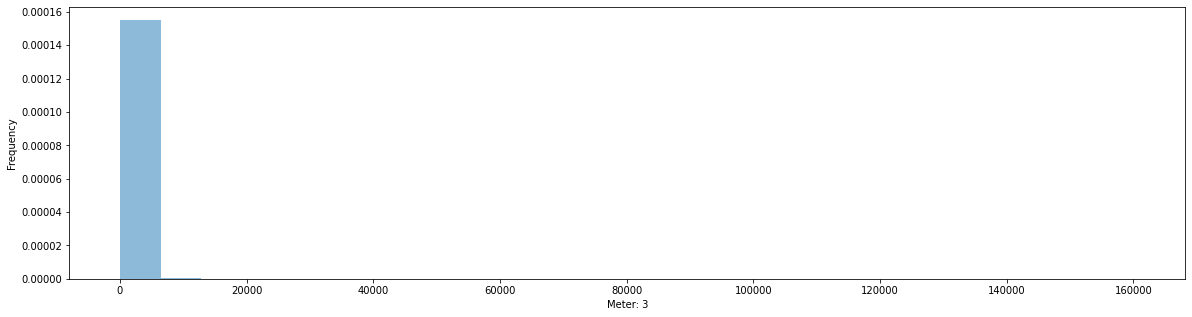

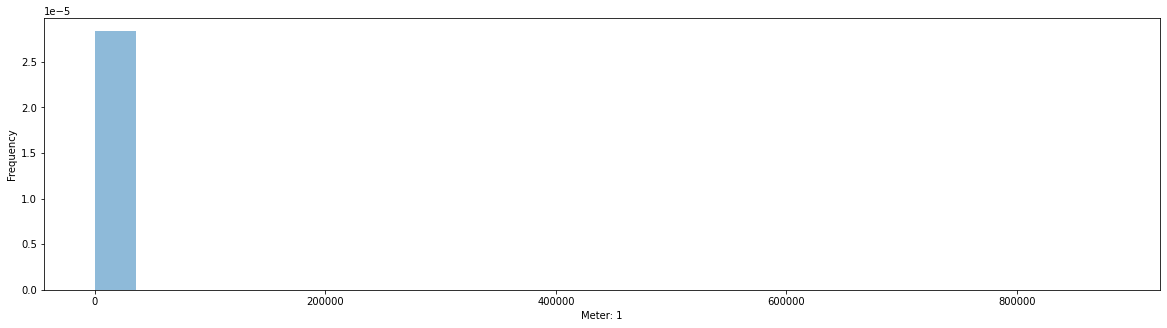

In [11]:
meter_arr = train["meter"].unique()
for meter in meter_arr:
    mask = train["meter"] == meter
    plt.figure(figsize=(20, 5))
    train[mask]['meter_reading'].plot.hist(bins=25, alpha=0.5, density=True)
    plt.xlabel("Meter: {}".format(meter))
    plt.show()

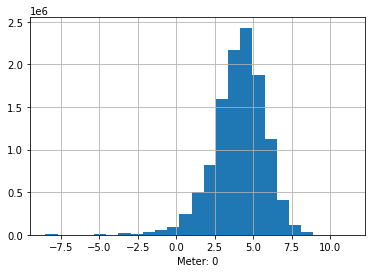

In [12]:
meter_arr = train["meter"].unique()
for meter in meter_arr:
    mask1 = train["meter"] == meter
    mask2 = train["meter_reading"] > 0
    mask = mask1&mask2
    np.log(train[mask]['meter_reading'].dropna()).hist(bins=25)
    plt.xlabel("Meter: {}".format(meter))
    plt.show()

In [13]:
meter_arr = train["meter"].unique()
for meter in meter_arr:
    mask1 = train["meter"] == meter
    mask2 = train["meter_reading"] > 0
    mask = mask1&mask2
    print(train[mask]['meter_reading'].min(), meter)

0.0002 0
0.0023 3
0.0001 1
0.0004 2


In [14]:
mask1 = train["meter"] == 0
mask2 = train["meter_reading"] < 0.37
mask3 = train["meter_reading"] > 8100
mask = mask1&(mask2|mask3)
print(train[mask1].shape)
print(train[mask]["meter_reading"].shape)
train = train.drop(train[mask].index,axis=0)
print(train[mask1].shape)

(12060910, 13)
(624102,)


C:\Users\328F~1\AppData\Local\Temp/ipykernel_2496/41951791.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train[mask1].shape)


(11436808, 13)


In [15]:
mask1 = train["meter"] == 1
mask2 = train["meter_reading"] < 0.0067
mask3 = train["meter_reading"] > 22000
mask = mask1&(mask2|mask3)
print(train[mask1].shape)
print(train[mask]["meter_reading"].shape)
train = train.drop(train[mask].index,axis=0)
print(train[mask1].shape)

(4182440, 13)
(661779,)


C:\Users\328F~1\AppData\Local\Temp/ipykernel_2496/4019101395.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train[mask1].shape)


(3520661, 13)


In [16]:
mask1 = train["meter"] == 2
mask2 = train["meter_reading"] < 1
mask3 = train["meter_reading"] > 162000
mask = mask1&(mask2|mask3)
print(train[mask1].shape)
print(train[mask]["meter_reading"].shape)
train = train.drop(train[mask].index,axis=0)
print(train[mask1].shape)

(2708713, 13)
(373084,)


C:\Users\328F~1\AppData\Local\Temp/ipykernel_2496/1152039605.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train[mask1].shape)


(2335629, 13)


In [17]:
mask1 = train["meter"] == 3
mask2 = train["meter_reading"] < 0.082
mask3 = train["meter_reading"] > 22000
mask = mask1&(mask2|mask3)
print(train[mask1].shape)
print(train[mask]["meter_reading"].shape)
train = train.drop(train[mask].index,axis=0)
print(train[mask1].shape)

(1264037, 13)
(345606,)


C:\Users\328F~1\AppData\Local\Temp/ipykernel_2496/2605374465.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train[mask1].shape)


(918431, 13)


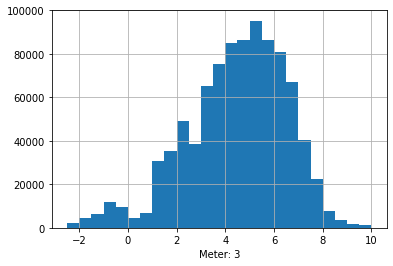

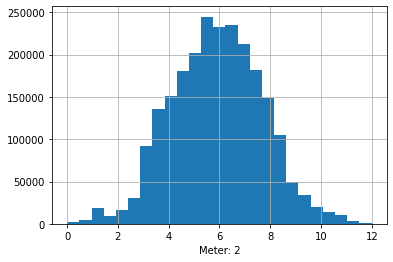

In [18]:
meter_arr = train["meter"].unique()
for meter in meter_arr:
    mask1 = train["meter"] == meter
    mask2 = train["meter_reading"] > 0
    mask = mask1&mask2
    np.log(train[mask]['meter_reading'].dropna()).hist(bins=25)
    plt.xlabel("Meter: {}".format(meter))
    plt.show()

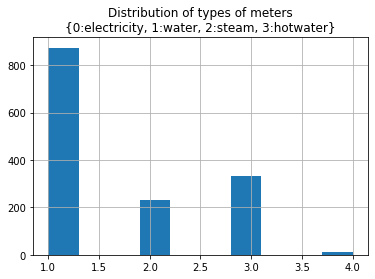

In [19]:
meters = train.groupby('building_id').meter.nunique()
plt.title('Distribution of types of meters\n{0:electricity, 1:water, 2:steam, 3:hotwater}')
_ = meters.hist()

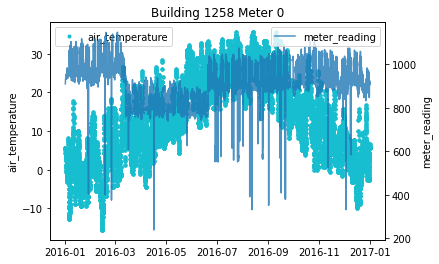

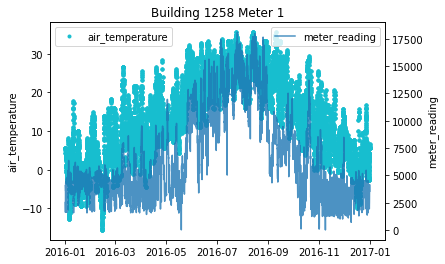

In [20]:
building_id = 1258  # a building with all 4 meters
meters = train[train['building_id'] == building_id].meter.nunique()

for meter in range(meters):
    fig, ax = plt.subplots()
    plt.title(f'Building {building_id} Meter {meter}')
    ax2 = ax.twinx()
    # plot meter_reading
    idx = (train['building_id'] == building_id) & (train['meter'] == meter)
    dates = matplotlib.dates.date2num(train.loc[idx, 'timestamp'])
    ax2.plot_date(dates, train.loc[idx, 'meter_reading'], '-', label='meter_reading', alpha=0.8)
    # plot air_temperature
    dates = matplotlib.dates.date2num(train.loc[train['building_id'] == building_id, 'timestamp'])
    ax.plot_date(dates, train.loc[train['building_id'] == building_id, 'air_temperature'], '.', color='tab:cyan', label='air_temperature')
    ax.set_ylabel('air_temperature'); ax2.set_ylabel('meter_reading')
    ax.legend(loc='upper left'); ax2.legend(loc='upper right')


In [21]:
print("Ratio of available data (not NAN's):")
data_ratios = train.count()/len(train)
data_ratios

Ratio of available data (not NAN's):


building_id          1.000000
meter                1.000000
timestamp            1.000000
meter_reading        1.000000
site_id              1.000000
primary_use          1.000000
square_feet          1.000000
year_built           0.398036
floor_count          0.174221
air_temperature      0.995372
cloud_coverage       0.995372
dew_temperature      0.994928
precip_depth_1_hr    0.995372
dtype: float64

In [22]:
print("Ratio of available data (not NAN's):")
test.count()/len(test)

Ratio of available data (not NAN's):


row_id               1.000000
building_id          1.000000
meter                1.000000
timestamp            1.000000
site_id              1.000000
primary_use          1.000000
square_feet          1.000000
year_built           0.410084
floor_count          0.173950
air_temperature      0.995227
cloud_coverage       0.995227
dew_temperature      0.993745
precip_depth_1_hr    0.995227
dtype: float64

In [23]:
train.head()

building_id  meter  timestamp  meter_reading  site_id primary_use  \
45            46      0 2016-01-01        53.2397        0      Retail   
72            74      0 2016-01-01        43.0013        0     Parking   
91            93      0 2016-01-01        52.4206        0      Office   
103          105      0 2016-01-01        23.3036        1   Education   
104          106      0 2016-01-01         0.3746        1   Education   

     square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
45          9045      2016.0          NaN             25.0             6.0   
72        387638      1997.0          NaN             25.0             6.0   
91         33370      1982.0          NaN             25.0             6.0   
103        50623         NaN          5.0              3.8             0.0   
104         5374         NaN          4.0              3.8             0.0   

     dew_temperature  precip_depth_1_hr  
45              20.0           0.000000  
72              20.0           0.000000  
91              20.0           0.000000  
103              2.4           0.522849  
104              2.4           0.522849

In [24]:
train = train.drop(['year_built'], axis=1)

In [25]:
test = test.drop(['year_built'], axis=1)

In [26]:
from sklearn.preprocessing import LabelEncoder
def Preprocessor(df, data_ratios):
    avgs = df.loc[:,data_ratios < 1.0].mean()
    le = LabelEncoder()
    le.fit(df["primary_use"])
    
    df = df.fillna(avgs)
    df['primary_use'] = np.uint8(le.transform(df['primary_use']))
 
    df['hour'] = np.uint8(df['timestamp'].dt.hour)
    df['day'] = np.uint8(df['timestamp'].dt.day)
    df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
    df['month'] = np.uint8(df['timestamp'].dt.month)
    df['year'] = np.uint8(df['timestamp'].dt.year-2000)

    df['floor_count'] = np.uint8(df['floor_count'])

    for col in df.columns:
        if col in ['timestamp', 'row_id']:
            del df[col]

    if 'meter_reading' in df.columns:
        df['meter_reading'] = np.log1p(df['meter_reading']/ df['square_feet']).astype(np.float32)
    
    return df

In [27]:
train_transform = Preprocessor(train, data_ratios)

In [28]:
train_transform = train_transform.reset_index(drop=True)

In [29]:
features = [col for col in train_transform.columns if col not in [target]]

In [30]:
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import mean_squared_error
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
#        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
#        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#        "bagging_fraction": trial.suggest_float(
#            "bagging_fraction", 0.2, 0.95, step=0.1
#        ),
#        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#        "feature_fraction": trial.suggest_float(
#            "feature_fraction", 0.2, 0.95, step=0.1
#        ),
    }

    tscv = TimeSeriesSplit(n_splits=4) 
    cv_scores = np.empty(4)
    for idx, (train_idx, test_idx) in enumerate(tscv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMRegressor(objective="regression", **param_grid, silent=False)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="rmse",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "rmse")
            ],  # Add a pruning callback
        )
        preds = model.predict(X_test).clip(0,10000)
        cv_scores[idx] = mean_squared_error(y_test, preds, squared=False)

    return np.mean(cv_scores)

In [32]:
import optuna

In [ ]:
%%time
%%capture [--no-display]
X = train_transform[features]
y = train_transform[target]
    
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

best_model = study.best_params
    
model = LGBMRegressor(**best_model)

[I 2021-12-03 18:39:36,541] A new study created in memory with name: LGBM Regressor
[I 2021-12-03 18:45:30,860] Trial 0 finished with value: 0.006493863397130807 and parameters: {'n_estimators': 1400, 'learning_rate': 0.08961562209079915, 'num_leaves': 160, 'max_depth': 10}. Best is trial 0 with value: 0.006493863397130807.
[I 2021-12-03 18:56:50,808] Trial 1 finished with value: 0.0072853225041720595 and parameters: {'n_estimators': 1500, 'learning_rate': 0.17519868049731474, 'num_leaves': 60, 'max_depth': 3}. Best is trial 0 with value: 0.006493863397130807.


In [57]:
X = train_transform[features]
y = train_transform[target]

model = LGBMRegressor(n_estimators = 600,
 learning_rate = 0.12752594220608948,
 num_leaves = 100,
 max_depth = 11)
#model.fit(X, y)

In [58]:
#best_model

In [59]:
%%time
results = []
tscv = TimeSeriesSplit(n_splits=4)    
cv_results = cross_val_score(model, X, y, cv=tscv, scoring='neg_root_mean_squared_error')
results.append(abs(cv_results))
print(results)

[array([0.00865069, 0.00652513, 0.00473249, 0.00609175])]
Wall time: 6min 11s


In [60]:
print("Ratio of available data (not NAN's):")
data_ratios = test.count()/len(test)
data_ratios

Ratio of available data (not NAN's):


row_id               1.000000
building_id          1.000000
meter                1.000000
timestamp            1.000000
site_id              1.000000
primary_use          1.000000
square_feet          1.000000
floor_count          0.173950
air_temperature      0.995227
cloud_coverage       0.995227
dew_temperature      0.993745
precip_depth_1_hr    0.995227
dtype: float64

In [61]:
test_transform = Preprocessor(test, data_ratios)
test_transform.head()

building_id  meter  site_id  primary_use  square_feet  floor_count  \
0            0      0        0            0         7432            4   
1            1      0        0            0         2720            4   
2            2      0        0            0         5376            4   
3            3      0        0            0        23685            4   
4            4      0        0            0       116607            4   

   air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  hour  \
0             17.8             4.0             11.7                0.0     0   
1             17.8             4.0             11.7                0.0     0   
2             17.8             4.0             11.7                0.0     0   
3             17.8             4.0             11.7                0.0     0   
4             17.8             4.0             11.7                0.0     0   

   day  weekday  month  year  
0    1        6      1    17  
1    1        6      1    17  
2    1        6      1    17  
3    1        6      1    17  
4    1        6      1    17

In [62]:
%%time
model.fit(X, y)

Wall time: 2min 14s


LGBMRegressor(learning_rate=0.12752594220608948, max_depth=11, n_estimators=600,
              num_leaves=100)

In [63]:
set_size = len(test_transform)
iterations = 100
batch_size = set_size // iterations

print(set_size, iterations, batch_size)
assert set_size == iterations * batch_size

41697600 100 416976


In [64]:
%%time
from tqdm import tqdm

meter_reading = []
for i in tqdm(range(iterations)):
    pos = i*batch_size
    fold_preds = model.predict(test_transform[features].iloc[pos : pos+batch_size])
    meter_reading.extend(fold_preds)

print(len(meter_reading))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:09<00:00,  3.70s/it]

41697600
Wall time: 6min 9s


In [65]:
meter_reading_exp = np.expm1(meter_reading)

In [66]:
meter_reading_exp = meter_reading_exp * test_transform['square_feet']

In [67]:
dic = {"pred": meter_reading_exp}
df_pred_out = pd.DataFrame(data= dic)

count    4.169760e+07
mean     4.678956e+02
std      2.082363e+03
min     -4.221314e+03
25%      3.751825e+01
50%      1.132225e+02
75%      3.252705e+02
max      1.304449e+05
Name: pred, dtype: float64

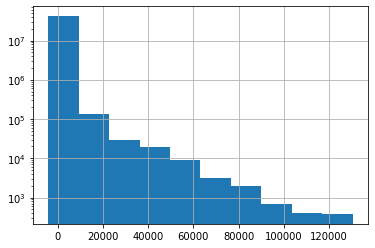

In [68]:
ax = df_pred_out.pred.hist()
ax.set_yscale('log')

# describe raw values first
df_pred_out.pred.describe()

In [69]:
submission = pd.read_csv('ashrae-energy-prediction/sample_submission.csv')
submission['meter_reading'] = np.clip(meter_reading_exp, a_min=0, a_max=None)

In [70]:
submission.to_csv('submission_new_2.csv', index=False)
submission.head(9)

row_id  meter_reading
0       0     110.128260
1       1      25.948403
2       2       0.000000
3       3     199.090412
4       4     849.909119
5       5       0.000000
6       6       0.000000
7       7     261.535862
8       8     792.956262

In [ ]:
!telegram-send "ok"

In [47]:
#meter_reading_exp_int = meter_reading_exp.round(0).astype(int)

In [48]:
#meter_reading_exp_int

In [49]:
'''submission = pd.read_csv('ashrae-energy-prediction/sample_submission.csv')
submission['meter_reading'] = np.clip(meter_reading_exp_int, a_min=0, a_max=None)

submission.to_csv('submission_new_1_int.csv', index=False)
submission.head(9)'''

"submission = pd.read_csv('ashrae-energy-prediction/sample_submission.csv')\nsubmission['meter_reading'] = np.clip(meter_reading_exp_int, a_min=0, a_max=None)\n\nsubmission.to_csv('submission_new_1_int.csv', index=False)\nsubmission.head(9)"